In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import yfinance as yf
import datetime
from arch import arch_model

In [2]:
ticker = 'META'
data = yf.download(ticker, period='8d', interval='1m')
data = data.reset_index()
data['Datetime'] = data['Datetime'].dt.tz_convert('America/New_York')
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data.head()



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Datetime,Close,High,Low,Open,Volume
0,2025-04-15 09:30:00-04:00,530.044983,532.099976,529.500000,532.099976,478834
1,2025-04-15 09:31:00-04:00,530.616882,531.210022,529.109985,530.039978,45291
2,2025-04-15 09:32:00-04:00,531.669983,532.500000,530.119995,530.549988,39874
3,2025-04-15 09:33:00-04:00,531.500000,532.489929,531.385010,531.552917,36032
4,2025-04-15 09:34:00-04:00,531.060120,531.750977,530.567322,531.280029,23733


In [3]:
print(data.shape)

(3118, 6)


In [4]:
data['Return'] = data['Close'].pct_change()
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Date'] = data['Datetime'].dt.date
print(data.columns.tolist())

data = data.dropna(subset=['Return', 'Log_Return'])

print(data.columns)
print(data[['Datetime', 'Close', 'Return', 'Log_Return']].head())

['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'Log_Return', 'Date']
Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'Log_Return', 'Date'],
      dtype='object')
                   Datetime       Close    Return  Log_Return
1 2025-04-15 09:31:00-04:00  530.616882  0.001079    0.001078
2 2025-04-15 09:32:00-04:00  531.669983  0.001985    0.001983
3 2025-04-15 09:33:00-04:00  531.500000 -0.000320   -0.000320
4 2025-04-15 09:34:00-04:00  531.060120 -0.000828   -0.000828
5 2025-04-15 09:35:00-04:00  530.789978 -0.000509   -0.000509


First volatility value: 0.0012320942725324241


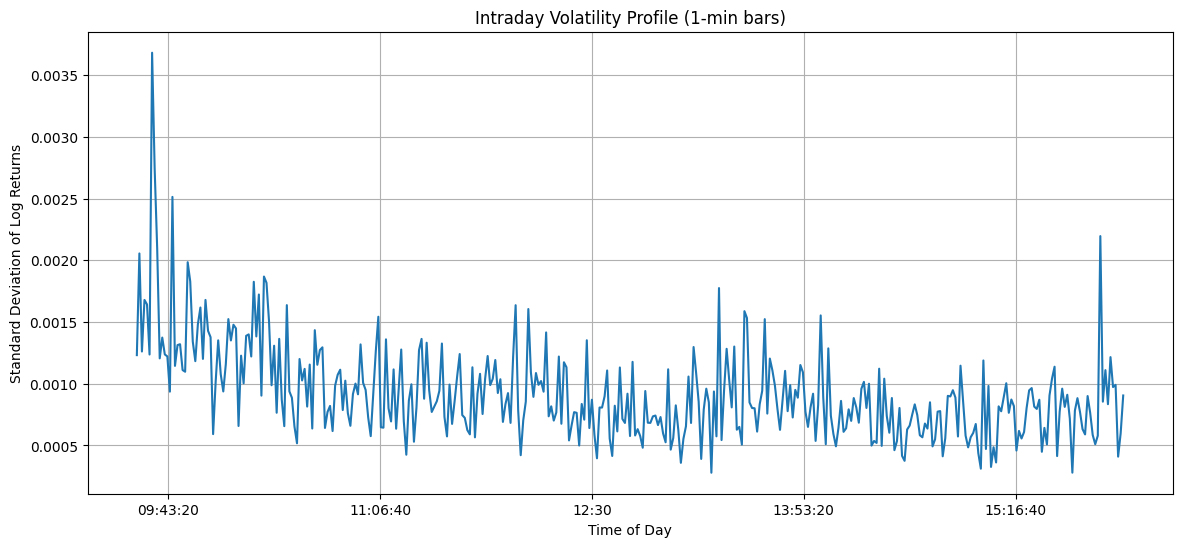

In [5]:
data['Time'] = data['Datetime'].dt.time
data = data.set_index('Datetime')
intraday = data.between_time(datetime.time(9, 31), datetime.time(16, 0))
intraday = intraday.reset_index()
data = data.reset_index()
vol_profile = intraday.groupby('Time')['Log_Return'].std()
drift = intraday.groupby('Time')['Log_Return'].mean()

plt.figure(figsize=(14,6))
vol_profile.plot()
#print first volatility value
print(f"First volatility value: {vol_profile.iloc[0]}")
plt.title('Intraday Volatility Profile (1-min bars)')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns')
plt.grid()
plt.show()


In [6]:
print(vol_profile.shape)
print(drift.shape)

(389,)
(389,)


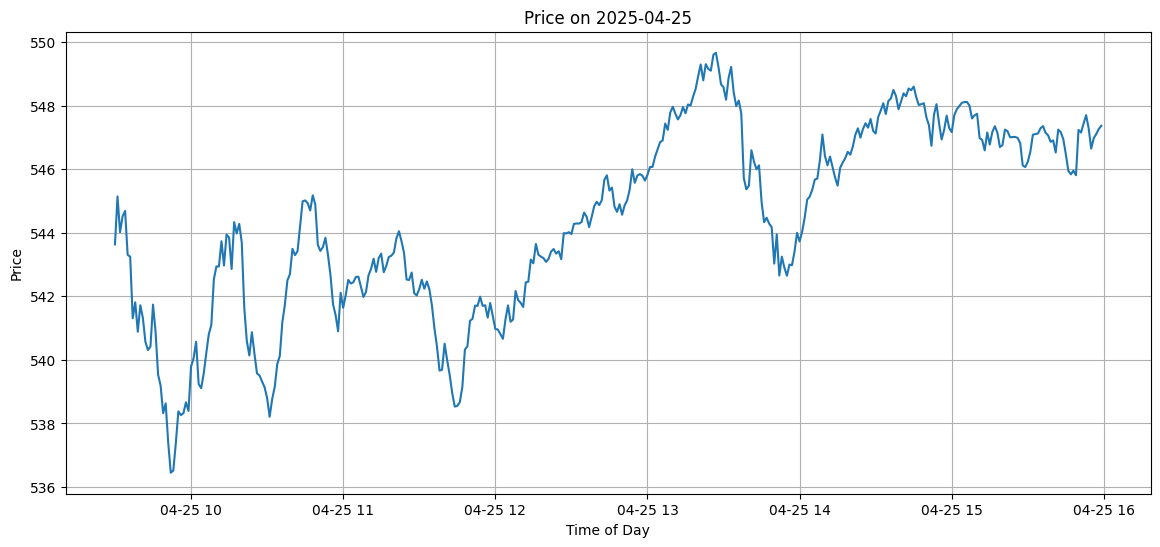

In [7]:
# plot time vs price on most recent day
recent_date = data['Date'].max()
recent_data = data[data['Date'] == recent_date]
plt.figure(figsize=(14,6))
plt.plot(recent_data['Datetime'], recent_data['Close'])
plt.title(f'Price on {recent_date}')
plt.xlabel('Time of Day')
plt.ylabel('Price')
plt.grid()
plt.show()

In [8]:
#price at open most recently
open_price = recent_data['Close'].iloc[0]
print(f"Open price on {recent_date}: {open_price}")

Open price on 2025-04-25: 543.635009765625


In [9]:
print(vol_profile.shape)

(389,)


In [10]:
daily_data = yf.download(ticker, period='60d', interval='1d')
daily_data = daily_data.reset_index()
daily_data.columns = [col[0] if isinstance(col, tuple) else col for col in daily_data.columns]

daily_data['Log_Return'] = np.log(daily_data['Close'] / daily_data['Close'].shift(1))
daily_data = daily_data.dropna(subset=['Log_Return'])

print(daily_data[['Date', 'Close', 'Log_Return']].head())



[*********************100%***********************]  1 of 1 completed

        Date       Close  Log_Return
1 2025-01-31  688.567383    0.003168
2 2025-02-03  696.840088    0.011943
3 2025-02-04  703.564087    0.009603
4 2025-02-05  704.243469    0.000965
5 2025-02-06  711.357117    0.010050


In [11]:
"""
#  fit GARCH(1,1) model here
am = arch_model(daily_data['Log_Return'] * 100, vol='Garch', p=1, q=1, mean='Zero')
res = am.fit(disp="off")

# forecast the volatility for the next day
forecast = res.forecast(horizon=1)
sigma_forecast = np.sqrt(forecast.variance.values[-1, :][0]) / 100
print(f"Forecasted daily volatility: {sigma_forecast:.4f}")
"""

'\n#  fit GARCH(1,1) model here\nam = arch_model(daily_data[\'Log_Return\'] * 100, vol=\'Garch\', p=1, q=1, mean=\'Zero\')\nres = am.fit(disp="off")\n\n# forecast the volatility for the next day\nforecast = res.forecast(horizon=1)\nsigma_forecast = np.sqrt(forecast.variance.values[-1, :][0]) / 100\nprint(f"Forecasted daily volatility: {sigma_forecast:.4f}")\n'

In [12]:
"""
implied_variance = np.sum(vol_profile**2)

target_variance = sigma_forecast**2

scaling_factor = np.sqrt(target_variance / implied_variance)

scaled_vol_profile = vol_profile * scaling_factor

plt.figure(figsize=(14,6))
scaled_vol_profile.plot()
plt.title('Scaled Intraday Volatility Profile')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns (scaled)')
plt.grid()
plt.show()
"""


"\nimplied_variance = np.sum(vol_profile**2)\n\ntarget_variance = sigma_forecast**2\n\nscaling_factor = np.sqrt(target_variance / implied_variance)\n\nscaled_vol_profile = vol_profile * scaling_factor\n\nplt.figure(figsize=(14,6))\nscaled_vol_profile.plot()\nplt.title('Scaled Intraday Volatility Profile')\nplt.xlabel('Time of Day')\nplt.ylabel('Standard Deviation of Log Returns (scaled)')\nplt.grid()\nplt.show()\n"

In [13]:
daily_log_returns = data.groupby('Date')['Log_Return'].sum()
daily_log_returns = daily_log_returns.reset_index()
print(daily_log_returns.head(10))


         Date  Log_Return
0  2025-04-15   -0.016617
1  2025-04-16   -0.037127
2  2025-04-17   -0.001357
3  2025-04-21   -0.034785
4  2025-04-22    0.032152
5  2025-04-23    0.038620
6  2025-04-24    0.024636
7  2025-04-25    0.026641


In [14]:
am = arch_model(daily_log_returns['Log_Return'] * 100, vol='Garch', p=1, q=1, mean='Zero')
res = am.fit(disp="off")
forecast_from_mins = res.forecast(horizon=1)
sigma_forecast_from_mins = np.sqrt(forecast_from_mins.variance.values[-1, :][0]) / 100
print(f"Forecasted daily volatility: {sigma_forecast_from_mins:.4f}")

Forecasted daily volatility: 0.0302


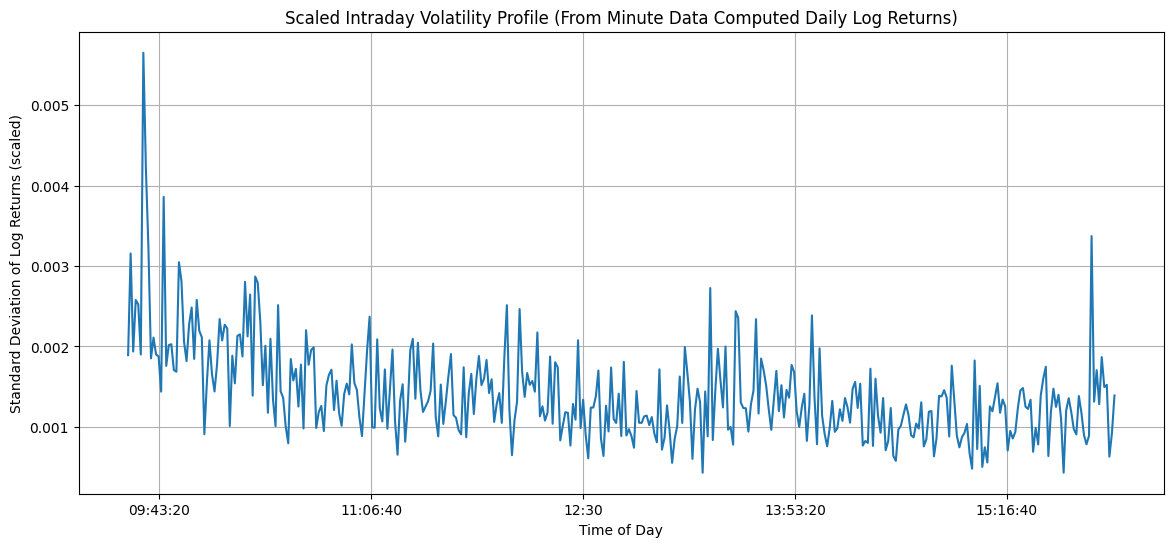

In [15]:
implied_variance = np.sum(vol_profile**2)

target_variance_from_mins = sigma_forecast_from_mins**2

scaling_factor_from_mins = np.sqrt(target_variance_from_mins / implied_variance)

scaled_vol_profile_from_mins = vol_profile * scaling_factor_from_mins

plt.figure(figsize=(14,6))
scaled_vol_profile_from_mins.plot()
plt.title('Scaled Intraday Volatility Profile (From Minute Data Computed Daily Log Returns)')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns (scaled)')
plt.grid()
plt.show()


In [16]:
#compute difference between two scaled vol profiles
"""
diff = scaled_vol_profile - scaled_vol_profile_from_mins
plt.figure(figsize=(14,6))
diff.plot()
plt.title('Difference between two scaled vol profiles')
plt.xlabel('Time of Day')
plt.ylabel('Difference')
plt.grid()
plt.show()
"""

"\ndiff = scaled_vol_profile - scaled_vol_profile_from_mins\nplt.figure(figsize=(14,6))\ndiff.plot()\nplt.title('Difference between two scaled vol profiles')\nplt.xlabel('Time of Day')\nplt.ylabel('Difference')\nplt.grid()\nplt.show()\n"

Cool, seems like I can get away with using the sum of log returns as an estimate of the volatility as my profile

In [17]:
def simulate_monte_carlo(scaled_vol_profile, drift, start_price,
                         num_simulations=1000, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    T = len(scaled_vol_profile)
    # draw all shocks
    shocks = np.random.randn(num_simulations, T)
    # force no shock at t=0
    shocks[:, 0] = 0

    drift_arr = drift.values.copy()
    drift_arr[0] = 0

    # build returns: zero at 0, then drift+shock*σ for t>=1
    returns = shocks * scaled_vol_profile.values[np.newaxis, :]

    cum = np.cumsum(returns, axis=1)
    rel = np.exp(cum)
    prices = start_price * rel

    return prices


def plot_simulation(prices, expected_price, num_simulations=1000):
    plt.figure(figsize=(14,6))
    for i in range(num_simulations):
        plt.plot(prices[i], color='blue', alpha=0.1)
    plt.plot(prices.mean(axis=0), color='red', label='Expected Price Path', linewidth=2)
    plt.title('Monte Carlo Simulation of Price Paths')
    plt.xlabel('Time Steps (Minutes)')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

In [18]:
today = datetime.date.today()

today_data = yf.download(ticker, period='1d', interval='1m', progress=False)
today_data = today_data.reset_index()

today_data.columns = [col[0] if isinstance(col, tuple) else col for col in today_data.columns]

today_data['Date'] = today_data['Datetime'].dt.date
today_data['Time'] = today_data['Datetime'].dt.time

if today_data.empty or today not in today_data['Date'].values:
    print("Today is NOT a trading day. Fetching most recent daily open instead.")

    fallback_data = yf.download(ticker, period='5d', interval='1d', progress=False)
    fallback_data = fallback_data.reset_index()

    last_open = fallback_data['Open'].iloc[-1]
    #datatype of lastopen
    print(f"Most recent trading day's open: {last_open}")
    recent_open = last_open

else:
    print("Today is a trading day. Using today's open.")

    today_open = today_data['Open'].iloc[0]
    print(f"Today's open: {today_open}")
    recent_open = today_open


Today is NOT a trading day. Fetching most recent daily open instead.
Most recent trading day's open: Ticker
META    546.799988
Name: 4, dtype: float64


In [19]:
print(scaled_vol_profile_from_mins.shape)
print(drift.shape)

(389,)
(389,)


/tmp/ipykernel_159659/1928502466.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(recent_open)


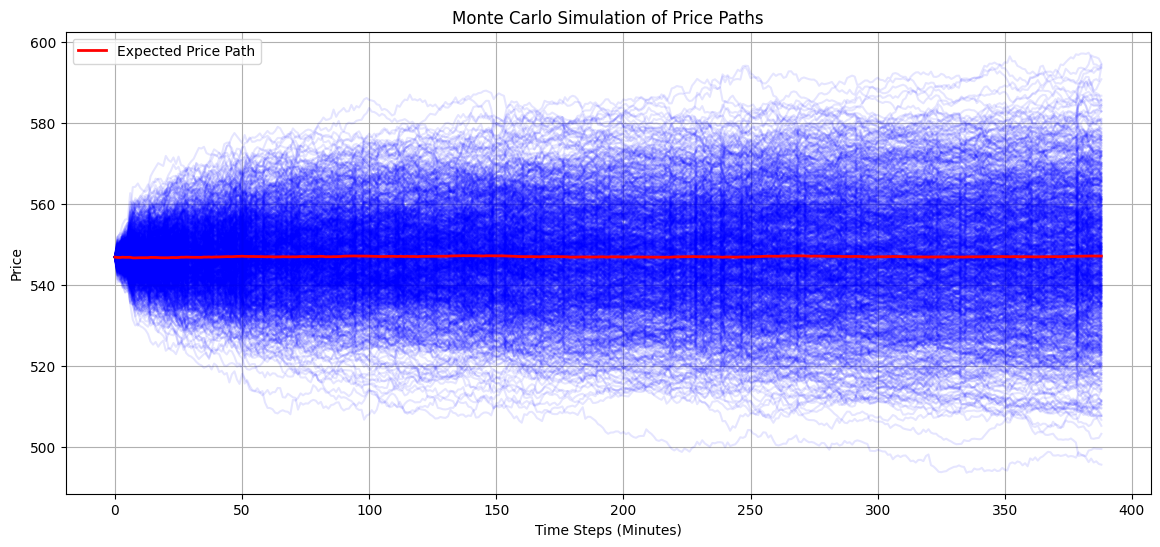

In [20]:
# run simulation using the open price of the most recent trading day
start_price = float(recent_open)
num_simulations = 1000
prices = simulate_monte_carlo(scaled_vol_profile_from_mins, drift, start_price, num_simulations=num_simulations, random_seed=42)
expected_price = np.mean(prices, axis=0)
plot_simulation(prices, expected_price, num_simulations=num_simulations)


In [21]:
# get 95 percent confidence interval for close out of the simulations
lower_bound = np.percentile(prices[:, -1], 2.5)
upper_bound = np.percentile(prices[:, -1], 97.5)
print(f"95% confidence interval for close: {lower_bound:.2f} - {upper_bound:.2f}")
# get 99 percent confidence interval for close out of the simulations
lower_bound_99 = np.percentile(prices[:, -1], 0.5)  
upper_bound_99 = np.percentile(prices[:, -1], 99.5)
print(f"99% confidence interval for close: {lower_bound_99:.2f} - {upper_bound_99:.2f}")

95% confidence interval for close: 515.39 - 578.41
99% confidence interval for close: 507.56 - 590.70


In [22]:
expected_at = 0
#print the expected price at the morning open
print(f"Expected price at the morning open: {expected_price[expected_at]:.2f}")

#print length of the expected price array
print(expected_price.shape)

expected_at = -1
#print the expected price at the close
print(f"Expected price at the close: {expected_price[expected_at]:.2f}")

Expected price at the morning open: 546.80
(389,)
Expected price at the close: 547.06
